In [73]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from datetime import datetime as dt
from dateutil.parser import parse
import re

In [74]:
# we only want the interval data from a single agency
# other ones for NM:  32000-2, 32000-3, 32000-901, 32000-4, 32000-61, 32000-8, 32000-9, 32000-18
agency = "32000-8"
# read the file in chunks, then append only the data that matches that agency
print(dt.now())
iter_csv = pd.read_csv('data/intervals.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['uniquename'] == agency] for chunk in iter_csv])
print(dt.now())

2019-01-29 22:24:32.871875
2019-01-29 22:24:49.555327


In [75]:
# add a new column which is the timestamp as a datetime object
df['ts'] = df.apply(lambda row: parse(row.timestamp), axis=1)

In [76]:
# add a new column for the hour of the day
df['HR'] = df.apply(lambda row: row.ts.hour, axis=1)

In [77]:
# add a new column for the day of the week
df['DOW'] = df.apply(lambda row: row.ts.weekday(), axis=1)

In [78]:
# this function will return a 'code' for Weekend, Night, or Day
def timeslot(h,d):
    # h - hour of day
    # d - day of week (0=Monday)
    if d > 4:             # day 5 or 6 (saturday or sunday)
        return "W"        # then Weekend
    elif h < 8 or h > 17: # before 7:59a or after 5:59p 
        return "N"        # then Night
    else:                 # otherwise
        return "D"        # Day

In [79]:
# make a new column with the timeslot code in it
df['SLOT'] = df.apply(lambda row: timeslot(row.HR, row.DOW), axis=1)

In [80]:
print("{} records for agency: {}".format(len(df), agency))
print("first 5:")
df.head()

6698 records for agency: 32000-8
first 5:


,Unnamed: 0,interval,origindex,timestamp,uniquename,ts,HR,DOW,SLOT
2452958,2452958,2492.0,1607271.0,2018-10-11 19:02:33,32000-8,2018-10-11 19:02:33,19,3,N
2452959,2452959,1038.0,1607988.0,2018-10-11 19:19:51,32000-8,2018-10-11 19:19:51,19,3,N
2452960,2452960,413.0,1608271.0,2018-10-11 19:26:44,32000-8,2018-10-11 19:26:44,19,3,N
2452961,2452961,63.0,1608315.0,2018-10-11 19:27:47,32000-8,2018-10-11 19:27:47,19,3,N
2452962,2452962,379.0,1608559.0,2018-10-11 19:34:06,32000-8,2018-10-11 19:34:06,19,3,N


In [81]:
# this removes the rows considered to be 'outliers'
# trimmed = df[df.interval < 100000]

In [82]:
# set the # of bins
bins_to_use = 100

In [83]:
# set the groupby using the timeslot
by_slot = trimmed.groupby('SLOT')

<IPython.core.display.Javascript object>


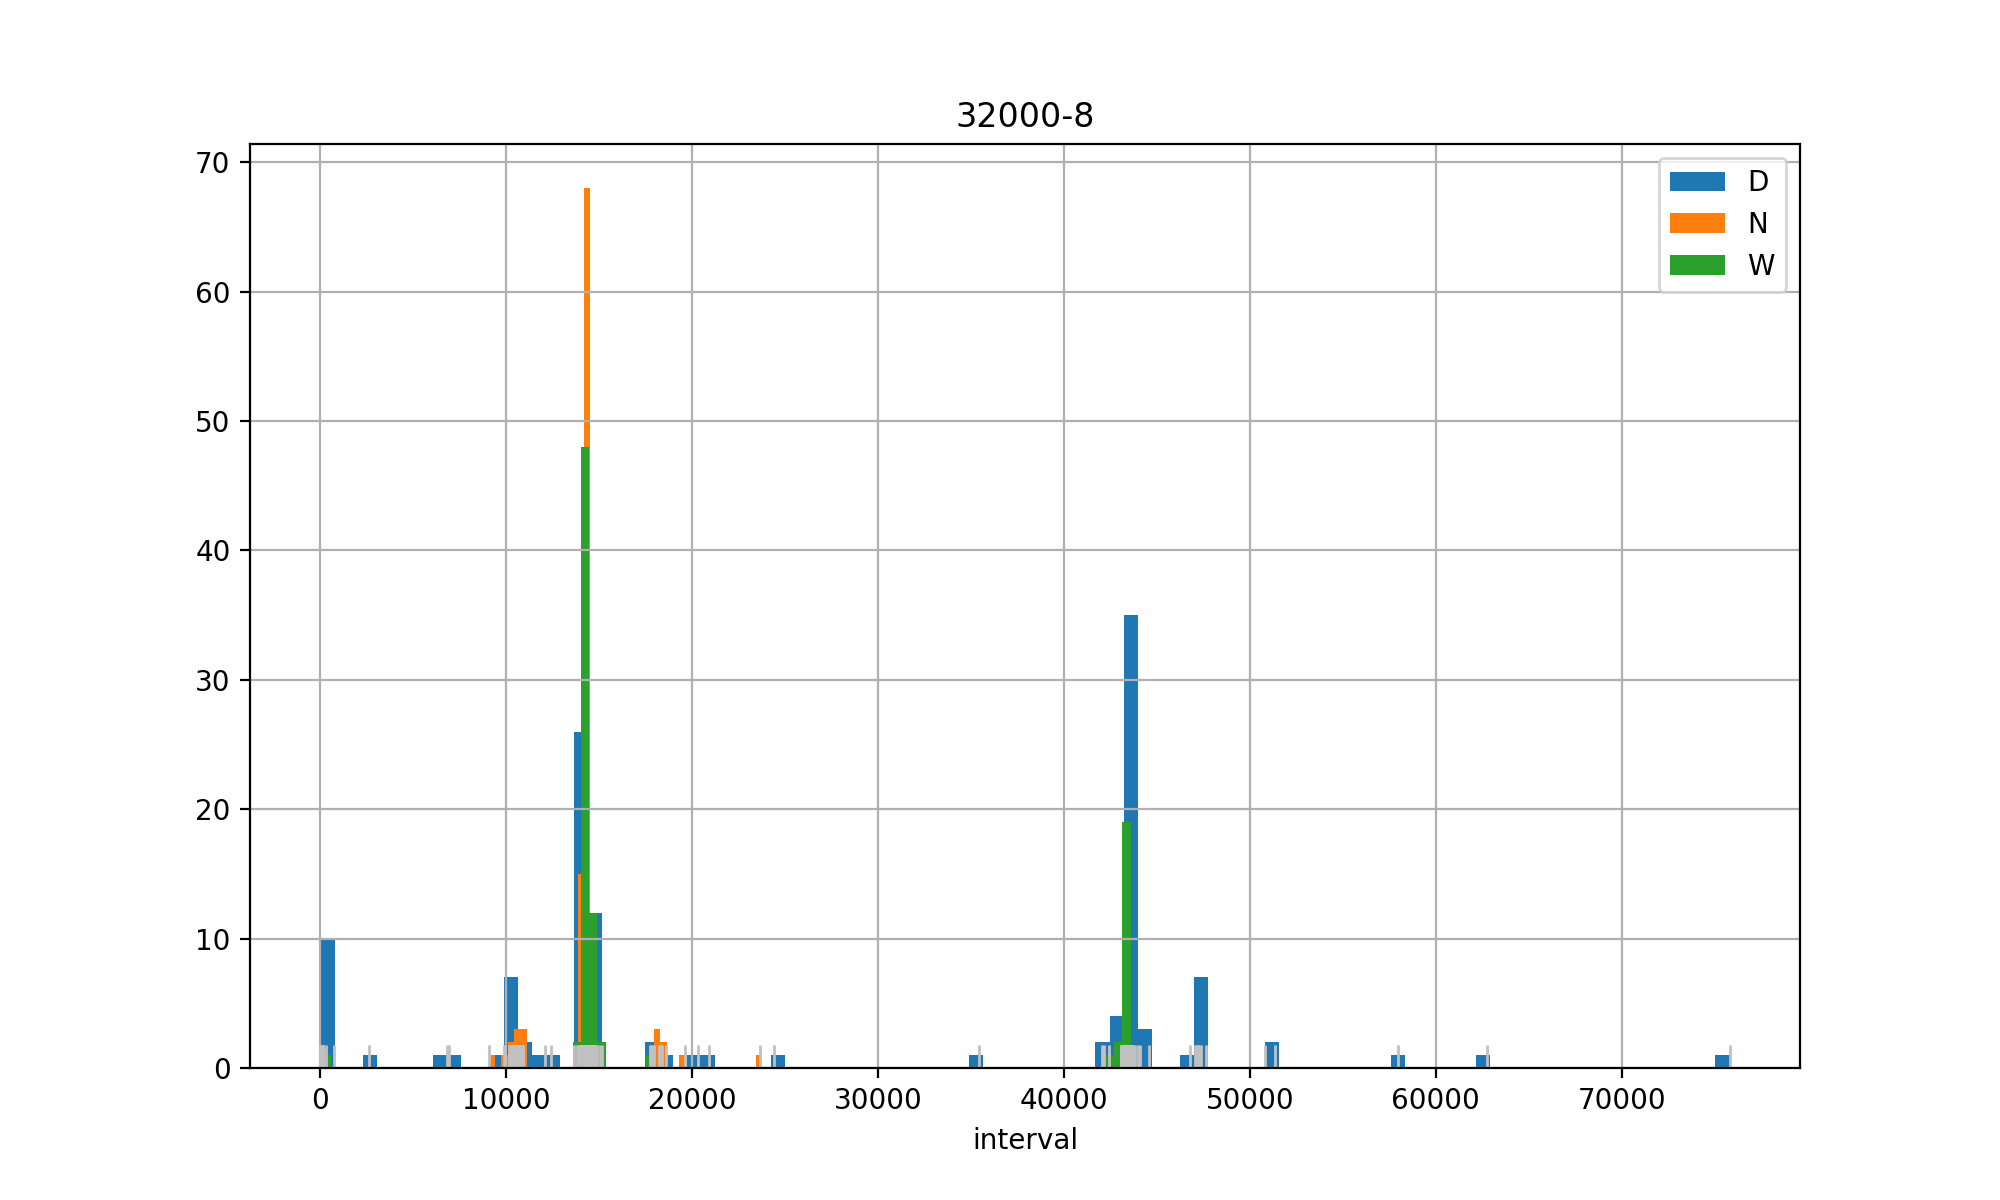

D count      127.00
mean     27012.83
std      17638.74
min          7.00
25%      14149.00
50%      17808.00
75%      43390.00
max      75796.00
Name: interval, dtype: object
N count      113.00
mean     14559.04
std       3251.47
min       9060.00
25%      14232.00
50%      14331.00
75%      14485.00
max      43243.00
Name: interval, dtype: object
W count       89.00
mean     21351.40
std      12721.97
min        139.00
25%      14299.00
50%      14406.00
75%      17705.00
max      43576.00
Name: interval, dtype: object


In [84]:
fig = plt.figure()
ax = plt.subplot()
ax.grid(True, which='both')  # set a grid
fig.set_size_inches(10, 6)   # size of the full figure
rugkws={"height": .025, "color": "999999"}  # rug display parameters
histkws={"linewidth": 1, "alpha": 1}        # histogram display parameters

for name, group in by_slot:
    sns.distplot(group.interval, label=name, kde=False, bins=bins_to_use, hist_kws=histkws, rug=True, rug_kws=rugkws)
    print(name, group["interval"].describe().apply(lambda x: format(x, '.2f')))

plt.title(agency)    # output the title
plt.legend()         # display a legend

In [ ]:
# use the stats module to do the same histogram calculations as sns.distplot
# using the same bucketing parameters
bin_maxes, bin_edges, binnumber = stats.binned_statistic(series_of_interest, series_of_interest, statistic=max, bins=bins_to_use)

In [ ]:
# graph the distribution of intervals using the .distplot function
# the .patches objects represent each graphed bin
# sns.set_style('ticks')
fig = plt.figure()
ax = plt.subplot()
ax.grid(True, which='both')  # set a grid
# ax.spines['left'].set_position((system, poisition))

fig.set_size_inches(12, 6)
rugkws={"height": .025, "color": "999999"}
histkws={"linewidth": 2, "alpha": 1, "color": "b"}
p = sns.distplot(by_slot.interval, bins=bins_to_use, rug=True, rug_kws=rugkws, hist_kws=histkws, kde=True).patches

annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="black", ec="b", lw=2),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(bar):
    x = bar.get_x()+bar.get_width()/2.
    y = bar.get_y()+bar.get_height()
    annot.xy = (x,y)
    text = "{:.0f}@{:.0f} secs".format( y,x )
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        for bar in p:
            cont, ind = bar.contains(event)
            if cont:
                update_annot(bar)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
    if vis:
        annot.set_visible(False)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show();

In [ ]:
# get the heights of the bins
heights = [item.get_height() for item in p]
# the highest
print("the highest bar is {}".format(max(heights)))
# sort the list, biggest first
sorted_heights = sorted(heights, reverse=True)
# top X
x = 5
print("info for top {}:".format(x))
for i in range(0,x):
    thebin = heights.index(sorted_heights[i])
    print("# {} - height: {}, bin: {}, max interval in bin: {}, right-edge of bin: {}".format(i+1,sorted_heights[i], thebin, bin_maxes[thebin], bin_edges[thebin+1]))
    